# Ein einfaches Beispiel der Regression

In diesem Notebook betrachten wir verschiedene Formen von Regression.
Zur Visualisierung verwenden wir den built-in Datensatz `tips` von Seaborn.

Als erstes importieren wir alle notwendigen Python Packages und laden den Datensatz.

In [9]:
%matplotlib widget 

#import science libs
import pandas as pda
import numpy as np
import scipy as sp
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


# import plotting libs
import ipywidgets as ipw
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# import own functions
from regression import OwnLinearRegressor
#umvu_beta_hat, umvu_reg, conf_intervall, conf_band_size
from plotting import plot_reg, plot_conf_band, scatter_tips

In [10]:
# load built-in dataset
data = sns.load_dataset("tips")
# and set seaborn attribute
sns.set_palette("bright")

## Visualisierung der Daten

Zunächst verschaffen wir uns einen Überblick über den Datensatz.

* Welches Format hat data?
* Welche Information sind zu jedem Datenpunkt gespeichert?
* Wie schauen simple Scatter Plots aus?
* Welche Spalten aus unserer Datenbank können wir vergleichen?
* Auf welche Spalten können wir versuchen eine Regression zu berechnen?


In [11]:
type(data)

pandas.core.frame.DataFrame

Unser Datenformat ist ein Pandas DataFrame. Damit können wir alle Pandas Methoden verwenden.
Um einen Überblick zu bekommen lohnt es sich einen kleinen Ausschnitt der Daten anzuschauen, genauergenommen die ersten fünf Datenpunkte.

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [13]:
data.head()

# Für LaTeX können wir diesen Output direkt exportieren.
# with open("../example_pdf/sections/data_head.tex", 'w') as f:
#    f.write(data[:5].to_latex(float_format="%.2f", header=["Rechnung", "Trinkgeld", "Geschlecht", "Raucher", "Tag", "Zeit", "Anzahl"]))


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Jeder Datenpunkt enthält Gesamtrechnung (Float), Trinkgeld (Float), Geschlecht (String), (Nicht-)Raucher (String), Wochentag (String), Mahlzeit(String) und Gruppengröße (Int).

Über die Numerischen Spalten können wir uns eine kurze statistische Zusammenfassung geben.

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_bill,244.0,19.785943,8.902412,3.07,13.3475,17.795,24.1275,50.81
tip,244.0,2.998279,1.383638,1.00,2.0000,2.900,3.5625,10.00
size,244.0,2.569672,0.951100,1.00,2.0000,2.000,3.0000,6.00


Und zur Visualisierung können wir zwei der Variablen gegeneinander plotten.

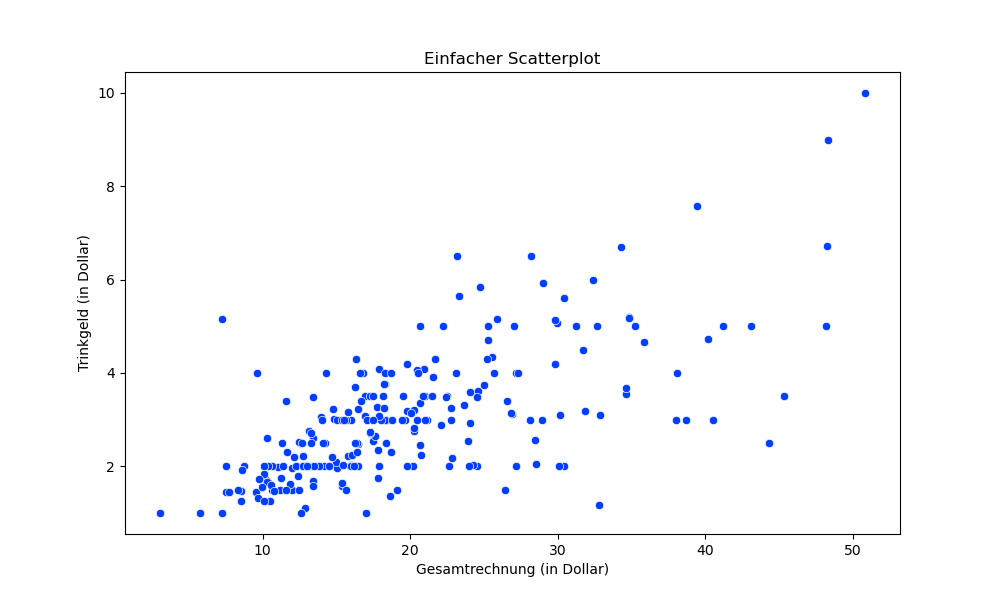

In [15]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=data, x="total_bill", y="tip")

# Set labels and title
plt.xlabel("Gesamtrechnung (in Dollar)")
plt.ylabel("Trinkgeld (in Dollar)")
plt.title(f"Einfacher Scatterplot")

plt.show()

## Lineare Regression

Die Idee hinter der Linearen Regression ist, dass zwischen zwei Variablen in einem Datensatz ein Zusammenhang existiert, den man bis auf einen Fehler durch eine lineare Gleichung darstellen kann.

Eine solche Struktur ist zum Beispiel bei einem linearen Modell gegeben.
Man betrachtet Beobachtungen zweier Variablen $X_i\in\R^k$ und $Y_i\in\R$ für $i\in\{1, \dots,n\}$, sodass für ein $\beta_0\in\R$ und $\beta\in\R^k$ gilt
$$Y_i=\beta_0 + \beta^\top X_i+\epsilon_i,$$
wobei $\epsilon_i\overset{\mathrm{iid}}{\sim}\mathcal{N}(0, \sigma^2)$.

Zur Vereinfachung verwendet man die Schreibweise der $\tilde{X}_i=(1, X_i)\in\R^{k+1}$ und $\tilde{\beta}=(\beta_0, \beta)$.
Dadurch erhalten wir 
$$Y_i= \tilde{\beta}^\top \tilde{X}_i+\epsilon_i,$$
wobei $\epsilon_i\overset{\mathrm{iid}}{\sim}\mathcal{N}(0, \sigma^2)$.
Zudem können wir alle $\tilde{X}_i$ in einer Matrix $\tilde{X}=[\tilde{X}_1, \dots, \tilde{X}_n]$ und die $Y_i$ in einem Vektor $Y=(Y_1, \dots,Y_n)$.
Dann gilt für einen Vektor $\epsilon=(\epsilon_1,\dots,\epsilon_n)$
$$Y= \tilde{X}^\top \tilde{\beta}+\epsilon$$

Für einen Datensatz $\mathcal{D}=\{(X_1,Y_1),\dots,(X_n,Y_n)\}$ wollen wir bei einer Linearen Regression den Vektor  $\tilde{\beta}$ schätzen.
Der gleichmäßig beste erwartungstreue Schätzer (UMVU) bei der linearen Regression ist explizit gegeben durch
$$\hat{\beta}=(\tilde{X}\tilde{X}^\top)^{-1}\tilde{X}Y.$$

Die letzte Überlegung, die wir anstellen müssen, ist aus welcher Variablen wir welche Variable vorhersagen wollen.
Insbesondere welche Variablen einen linearen Zusammenhang aufweisen können.

Bei unserem Datensatz ist das relativ einfach. Die Faustregeln beim Essengehen einen festen Prozentsatz der Gesamtsumme als Trinkgeld zu geben ist jedem bekannt. Zudem sind dies die einzigen beiden Variablen, welche stetig sind.

Der einfachste Weg eine Regression zu berechnen ist die in `scikit-learn` implementierte Klasse LinearRegression zu verwenden.

Zunächst wollen wir aus der Gesamtrechnung auf die Höhe des Trinkgelds schließen.

In [ ]:
X = np.array(data["total_bill"]).reshape(-1, 1)
y = data["tip"]

Nach der richtigen Formatierung der Daten, lässt sich der Regressor durch einen einfachen Befehl fitten.

In [20]:
reg = LinearRegression().fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Nun können wir die Daten und die Regressionsgerade plotten.

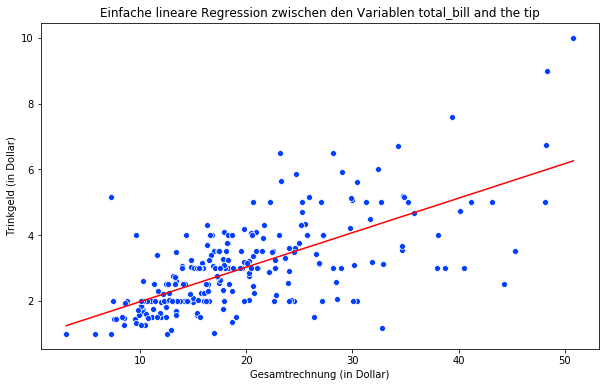

In [34]:
plot_reg(reg, data)

Aus der obigen Darstellung des UMVU-Schätzers können wir diese Funktionalität auch durch eigenen Code replizieren.

Dafür verwenden wir die eigens implementierte Klasse `OwnLinearRegressor` an.

Der Konstruktor extrahiert direkt die richtigen Daten.
Durch die Methode `umvu_reg` können wir den Regressor fitten.

In [23]:
own_reg = OwnLinearRegressor(data, ["total_bill"], "tip")
own_reg.umvu_reg()

Analog wie beim Scikit Regressor können wir die Daten plotten.

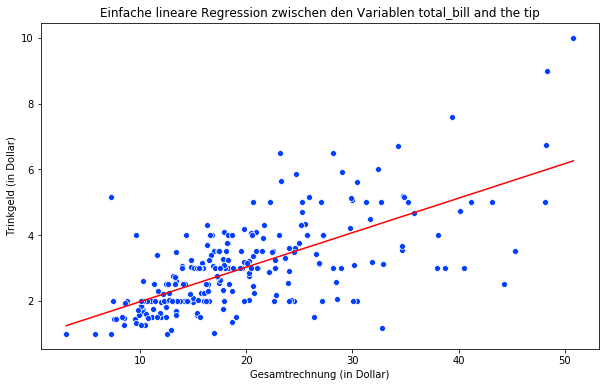

In [33]:
plot_reg(own_reg, data)

Diese Informationen geben eine Intuition über den Zusammenhang.
In der Statistik muss man aber auch immer prüfen, ob diese Aussagen auch signifikant sind.

Dafür wollen wir die Hypothese testen, ob die Steigung der gerade $0$ ist oder ungleich $0$ ist.

Nach 7.39 ergibt sich der t-Test für die einfach lineare Regression durch
$$\delta_t(y)\coloneqq 1_{\{|T_n(Y)|\ge t_{n-2, 1-\alpha/2}\}}.$$

Nun müssen wir nur noch den t-Statistik herleiten.
Zunächst wissen wir, dass der Schätzer $\hat{\beta}$ normalverteilt ist nach
$$\hat{\beta}_1\sim\mathcal{N}(\beta_1, \sigma^2ss_{xx}^{-1}),$$
wobei die Stichprobenvarianz $ss_{xx}$ wie folgt definiert ist
$$ss_{xx}^{-1}\coloneqq(X^\top X)_{22}^{-1}=\left(\sum_{i=1}^n(X_i-\bar{X})^2\right)^{-1}.$$
$\bar{X}$ ist dabei der Mittelwert der $X_i$.
Unter unserer Nullhypothese gilt somit 
$$\frac{\sqrt{ss_{xx}}\hat{\beta}_1}{\sigma}\sim\mathcal{N}(0, 1).$$
Der Schätzer der Varianz der Störgrößen ist gegeben durch
$$s^2(Y)=\frac{1}{n-2}\sum_{i=1}^n(Y_i-\hat{Y}_i)^2,$$
wobei $\hat{Y}_i\coloneqq\hat{\beta}\tilde{X}_i$.
Insbesondere ist 
$$\frac{(n-2)s^2(Y)}{\sigma^2}\sim\chi_{n-2}$$
Nun folgt, das die t-Statistik gegeben ist durch
$$T_n(Y)=\frac{\sqrt{ss_{xx}}\hat{\beta}_1}{\sigma}\left(\frac{s^2(Y)}{\sigma^2}\right)^{-1/2} = \frac{\sqrt{ss_{xx}}\hat{\beta}_1}{s(Y)}.$$

Durch die Verteilungsfunktion der Student-schen Verteilung können wir dann den p-Wert berechnen
$$p = 2(1-F_{t, n-2}(T_n(Y))).$$
Wir verwerfen also die Nullhypothese, falls
$p<\alpha$ gilt.

In [25]:
# Wir können die eigene Implementation der t-Statistik verwenden:
own_reg.calc_t_stat()

14.260354951200576

In [26]:
# und auch den p-Wert berechnen lassen.
own_reg.calc_p_value()

0.0

Dem p-Wert nach zu urteilen muss die Nullhypothese verworfen werden, selbst wenn man ein $\alpha$ kleine $0.05$ wählen würde.
Somit ist die Abhängigkeit zwischen der Gesamtrechnung und dem Trinkgeld signifikant.

Noch mehr Informationen über die statistischen Zusammenhänge können wir durch `statsmodels.api` erhalten.

In [27]:
results = sm.OLS(y, sm.add_constant(X)).fit()
print(results.summary())

#Für LaTeX können wir uns diese Statistik direkt exportieren.
# with open("../example_pdf/sections/summary_tabular.tex", 'w') as f:
#    f.write(results.summary().as_latex())

                            OLS Regression Results                            
Dep. Variable:                    tip   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     203.4
Date:                Thu, 05 Oct 2023   Prob (F-statistic):           6.69e-34
Time:                        11:45:21   Log-Likelihood:                -350.54
No. Observations:                 244   AIC:                             705.1
Df Residuals:                     242   BIC:                             712.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9203      0.160      5.761      0.0

Die einfache Regression lässt sich audch direkt durch die Funktion `regplot` in Seaborn realisieren.
Noch dazu plotted diese Funktion per default ein Konfidenz Intervall.
Dieses Konfidenzintervall wird durch eine Bootstrap Methode errechnet.

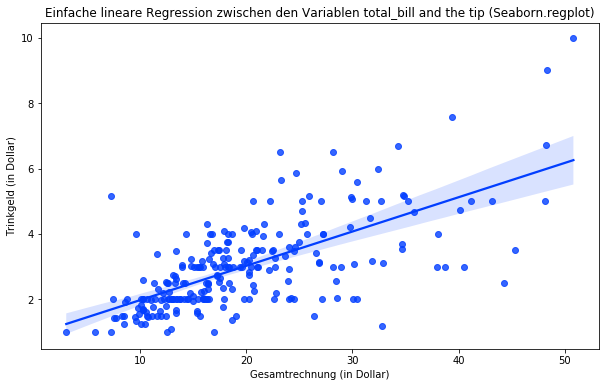

In [35]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(data=data, x="total_bill", y="tip")

# Set labels and title
plt.xlabel("Gesamtrechnung (in Dollar)")
plt.ylabel("Trinkgeld (in Dollar)")
plt.title(f"Einfache lineare Regression zwischen den Variablen total_bill and the tip (Seaborn.regplot)")

plt.show()

Da die Bootstrap Methode nur im Source Code nachzulesen ist und dabei eigene Funktionen verwendet, versuchen wir eine andere Methode zu finden ein Konfidenzband um die Regression zu legen.

Wie auf Wikipedia [verlinkt](https://en.wikipedia.org/wiki/Simple_linear_regression#cite_ref-8) kann man in dem Buch [Statistical Inference](https://archive.org/download/casella_berger_statistical_inference1/casella_berger_statistical_inference1.pdf) auf Seite 558f eine Berechnung für ein solches Konfidenzband finden. 

Das Konfidenzband ist gegeben durch
$$\beta_0+\beta x\pm t_{n-2}^{1-\alpha/2}\sqrt{\frac{1}{n-2}\left(\sum_{i=1}^n(Y_i-\hat{Y}_i)^2\right)\left(\frac{1}{n}+\frac{(x-\bar{x})^2}{\sum_{i=1}^n(x_i-\bar{x})^2}\right)}.$$

Nachdem wir $\alpha$ gesetzt haben, können wir das Konfidenz Band berechnen und plotten.

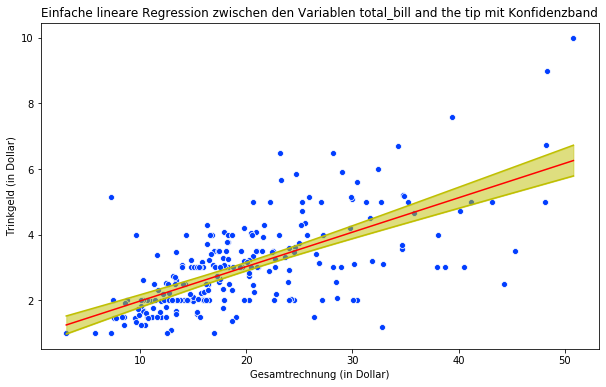

In [36]:
alpha = 0.05

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=data, x="total_bill", y="tip")

# calculate beginning and end of regression line
min_max = np.array([np.min(X), np.max(X)])
pred_min_max = own_reg.predict(min_max.reshape(-1, 1))
n = len(X)
mean_x = np.mean(X)
# draw line
plt.plot(min_max, pred_min_max, c="r")
# calculate confidence intervall at multiple x values
x_i = np.linspace(min_max[0], min_max[1], 100)
y_band = own_reg.conf_intervall(x_i, alpha)
# plot lower boarder
plt.plot(x_i, y_band[:,0], c="y")
# plot upper boarder
plt.plot(x_i, y_band[:,1], c="y")
# plot band
plt.fill_between(x_i, y_band[:,0], y_band[:,1], alpha=.5, color="y")

# set labels and title
plt.xlabel("Gesamtrechnung (in Dollar)")
plt.ylabel("Trinkgeld (in Dollar)")
plt.title(f"Einfache lineare Regression zwischen den Variablen total_bill and the tip mit Konfidenzband")

plt.show()

Insbesondere können wir für den Wert $\alpha$ einen Schieberegler einbauen und erhalten

In [37]:
ipw.interact(plot_conf_band, regressor=ipw.fixed(own_reg), alpha=ipw.FloatSlider(value=0.05, min=0.01, max=.50, step=.01, description="alpha", continuous_update=False))

interactive(children=(FloatSlider(value=0.05, continuous_update=False, description='alpha', max=0.5, min=0.01,…

<function plotting.plot_conf_band(regressor, alpha=0.05)>

Diese Funktionalität erhalten wir auch viel kompakter, wenn wir Seaborn nutzen.
Insbesondere können wir in der Funktion `lmplot` noch die Variable `hue` gleich `'days'` setzen und erhalten dadurch Farbkodierung der einzelnen Tage.

Durch ein weiteres Argument können wir den Datensatz auch nach bestimmten Tagen filtern und erhalten nur die ausgewählten Tage im Plot.

In [39]:
ipw.interact(scatter_tips, data=ipw.fixed(data), days_to_plot=ipw.SelectMultiple(options=["Thur", "Fri", "Sat", "Sun"], value=["Thur", "Fri", "Sat", "Sun"], description="Days to plot:"), ci_bool=ipw.Checkbox(True, description="Plot ci"), ci_alpha=ipw.IntSlider(min=50,max=100,value=95, description="Size of ci", continuous_update=False))

interactive(children=(SelectMultiple(description='Days to plot:', index=(0, 1, 2, 3), options=('Thur', 'Fri', …

<function plotting.scatter_tips(data, days_to_plot=['Thur', 'Fri', 'Sat', 'Sun'], ci_bool=True, ci_alpha=0.95)>

Zum Schluss wollen wir noch den Unterschied zwischen Nichtraucher\*innen und Raucher\*innen betrachten.
Zunächst plotten wir die Regression für jede Untergruppe und berechnen danach mit einem t-Test, ob das prozentuale Trinkgeld sich zwischen diesen Gruppen signifikant unterscheidet. 

In [45]:
dictionary = {"xlim":[0, 53], "ylim":[0, 11]}
type(dictionary)

dict

In [46]:
ax = sns.lmplot(x="total_bill", y="tip", hue="smoker", data=data,
           markers=["o", "x"], palette="Set1", facet_kws={"xlim":[0, 53], "ylim":[0, 11]})
ax.figure.set_size_inches(8, 6)
plt.xlabel("Gesamt Rechnung")
plt.ylabel("Trinkgeld")
plt.suptitle("Regression unterschieden zwischen (Nicht-)Raucher*innen")

TypeError: lmplot() got an unexpected keyword argument 'facet_kws'

Für jeden Datenpunkt können wir explizit den Prozentsatz an Trinkgeld berechnen und damit den zwei Stichproben t-Test durchführen.

In [21]:
data["perc_tip"] = data["tip"]/(data["total_bill"]-data["tip"])

In [22]:
perc_tip = data["perc_tip"]
sp.stats.ttest_ind(data[data["smoker"]=="No"]["perc_tip"], data[data["smoker"]=="Yes"]["perc_tip"])

TtestResult(statistic=-1.2055692326833072, pvalue=0.22916107219645684, df=242.0)

Signifikant ist der Unterschied in Spendabilität dieser zwei Gruppen nicht.

Aber wenn wir uns die zugehörigen Boxplots anschauen wird klar, dass die Raucher*innen viel eher übertrieben hohe Trinkgelder geben.

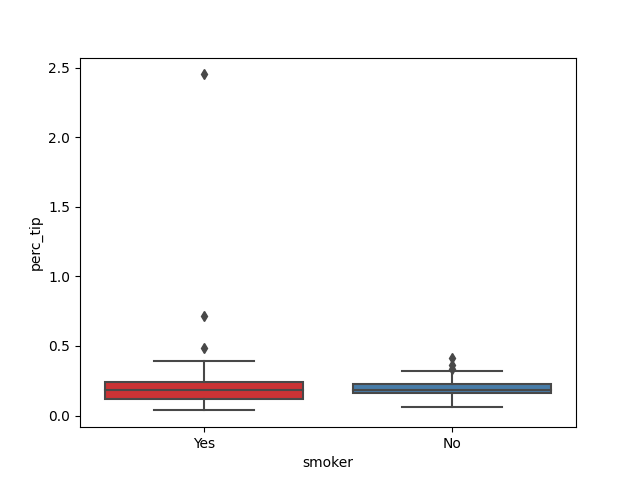

In [23]:
plt.figure()
sns.boxplot(x="smoker", y="perc_tip", data=data, palette="Set1")
plt.show()

[Box-Plots](https://de.wikipedia.org/wiki/Box-Plot) werden verwendet um die Verteilung eines Datensatzes darzustellen.
Die mittlere Linie ist der Median der Daten.
Die Box ist zwischen dem unteren und oberen Quartil gezeichnet, also dem $25%$ und $75%$ Quantil.
Die Länge der Antennen oder im Englischen Whiskers können müssen nicht gleich definiert sein.
Am üblichsten ist die Länge der Antennen durch den $1,5$-fachen Interquartilsabstand beschränkt. Sie gehen aber nur soweit wie der letzte Datenpunkt der innerhalb dieser oberen Grenze liegt.
Alle Datenpunkte außerhalb der Whiskers werden als Außreiser separat dargestellt.

Dadurch bekommt man einen guten Überblick, wo der Großteil der Daten verteilt sind und ob und wo es Ausreißer gibt.
